In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pwlreg as pw

In [3]:
def generate_building_model_data(x, kind, params, spread, rng=None):
    if kind not in ("cool", "heat", "both"):
        raise ValueError("invalid model type")

    if len(params) not in (3, 4, 5):
        raise ValueError("invalid number of params")

    if rng is None:
        rng = np.random.default_rng()
    N = len(x)

    if isinstance(spread, (int, float)):
        spread = np.full(N, spread)
    else:
        spread = np.array(spread)

    if len(params) == 3:
        b0, b1, b2 = params
        if kind == "cool":
            y = b0 + b1 * np.clip(x - b2, 0., None)
        elif kind == "heat":
            y = b0 - b1 * np.clip(b2 - x, 0., None)
        else:
            raise ValueError("3-parameter model can't be heat+cool")
    elif len(params) == 4:
        b0, b1, b2, b3 = params
        if kind == "cool":
            y = b0 + b1 * np.clip(x - b3, 0., None) - b2 * np.clip(b3 - x, 0., None)
        elif kind == "heat":
            y = b0 - b1 * np.clip(b3 - x, 0., None) + b2 * np.clip(x - b3, 0., None)
        else:
            raise ValueError("4-parameter model can't be heat+cool")
    elif len(params) == 5:
        b0, b1, b2, b3, b4 = params
        if kind == "both":
            y = np.piecewise(
                x,
                [x < b3, (b3 <= x) & (x < b4), x >= b4],
                [
                    lambda x: b0 - b1 * (b3 - x),
                    b0,
                    lambda x: b0 + b2 * (x - b4),
                ]
            )
        else:
            raise ValueError("5-parameter model must have kind=\"both\"")
    else:
        raise ValueError("Shouldn't get here")

    y += rng.normal(0, spread, N)
    return y, spread

In [15]:
cp1, cp2 = 52, 73

rng = np.random.default_rng(1234)
x = np.concatenate(
    (
        rng.uniform(0, cp1, 300),
        rng.uniform(cp1, cp2, 400),
        rng.uniform(cp2, 100, 300),
    )
)
sigma = np.piecewise(
    x,
    [x < cp1, (cp1 <= x) & (x < cp2), x >= cp2],
    [
        lambda x: 1 + 0.10 * (cp1 - x),
        1,
        lambda x: 1 + 0.15 * (x - cp2),
    ]
)
y, sigma = generate_building_model_data(
    x,
    "both",
    (10, -0.3, 0.5, cp1, cp2),
    sigma,
    rng=rng,
)

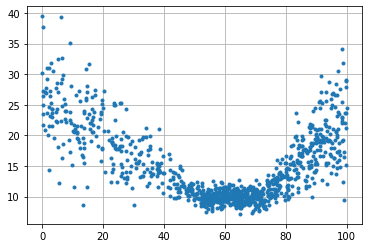

In [16]:
plt.plot(x, y, '.')
plt.grid(True)

In [17]:
def plot_piecewise_regression(pwm, x, y):
    xx = np.linspace(min(x), max(x), 1000)
    yy = pwm.predict(xx)

    if hasattr(pwm, "breakpoints_"):
        xb = pwm.breakpoints_
    else:
        xb = pwm.breakpoints

    yb = pwm.predict(xb)

    plt.figure()
    plt.plot(x, y, ".")
    plt.plot(xb, yb, "x", ms=10)
    plt.plot(xx, yy, "-")
    plt.grid(True)

In [18]:
# your desired line segment end locations
x0 = np.array([min(x), 55, 65, max(x)])

In [19]:
mod1 = pw.PiecewiseLinearRegression(breakpoints=x0, degree=[1, 0, 1])
mod1.fit(x, y)

PiecewiseLinearRegression(breakpoints=array([2.39868656e-03, 5.50000000e+01, 6.50000000e+01, 9.99766492e+01]),
                          degree=[1, 0, 1])

In [20]:
mod1.score(x, y)

0.7395037663120771

In [21]:
mod1.breakpoints

array([2.39868656e-03, 5.50000000e+01, 6.50000000e+01, 9.99766492e+01])

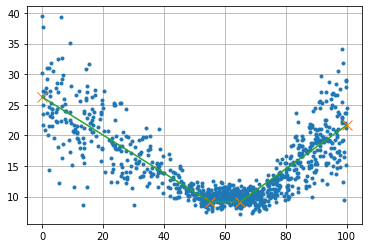

In [22]:
plot_piecewise_regression(mod1, x, y)

In [30]:
mod = pw.AutoPiecewiseRegression(n_segments=3, degree=[1, 0, 1])
mod.fit(x, y, weights=1/sigma)

AutoPiecewiseRegression(degree=[1, 0, 1], n_segments=3)

In [31]:
mod.score(x, y)

0.7546648770713255

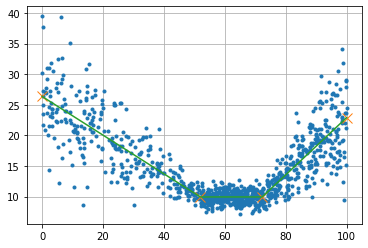

In [32]:
plot_piecewise_regression(mod, x, y)

In [33]:
mod.coef_

array([ 26.3495183 ,  -0.31608975,   9.92826911, -23.86151774,
         0.46759325])

In [34]:
mod.breakpoints_

array([2.39868656e-03, 5.19512230e+01, 7.22632052e+01, 9.99766492e+01])

In [28]:
mod.coef_

array([ 26.34988347,  -0.31611247,   9.92149769, -23.69331126,
         0.46574123])

In [29]:
mod.score(x, y)

0.7546616078683679